# Noisy Double DQN Reinforcement Learning Agent for Blackjack

## Extending our Previously Trained Double DQN Blackjack Agent with Replay Memory by adding a Noise Layer

In our previous final submission, we trained and evaluated a Double DQN architecture with replay memory to learn to play blackjack. In this notebook we hope to extend this agent by adding a noise layer to the network.

## Background

### Double DQN Architectures

A double DQN architecture has been shown to improve training and learning accuracy by using two disjoint models to:

1. Predict the optimal Q-Learning stategy / next best action with model A
2. Evaluate the learned strategy in model A with model B via a different model that has copied the weights of model A at a previous time step to avoid the noise from negatively affecting the model's performance.

### Noisy Networks

A noisy network adds a noise layer after the dense layers and before the final prediction layer. This allows the model to output predictions that leverage the noise to make more experimental choices during training (after the typical exploration phase) and allows for the model to update the optimal gaussian noise parameters to avoid underfitting.

Key Reference: https://github.com/Curt-Park/rainbow-is-all-you-need/blob/master/05.noisy_net.ipynb


## Imports and Installs

In [1]:
%%capture
# capture line to hide the output
# Install required packages
!pip install gymnasium torch numpy matplotlib

In [2]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque
import random

## Setting up the Environment

In [3]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Create the Blackjack environment
env = gym.make('Blackjack-v1')

In [4]:
# Test environment
observation, info = env.reset()
print("Initial Observation:", observation)
print("Available Actions:", env.action_space)
print("Observation Space:", env.observation_space)

Initial Observation: (10, 10, 0)
Available Actions: Discrete(2)
Observation Space: Tuple(Discrete(32), Discrete(11), Discrete(2))


## Setting up the NoisyDoubleDQN, ReplayMemory Class Definitions

### The ReplayMemory Class

This is our ReplayMemory implementation which is a simple deque that captures individual observations from the environment. This is used to save experiences during the exploration phase (when the model is making actions at random) to save for later use during training.

In [5]:
import random
from collections import namedtuple, deque

# Define a named tuple to store experiences
Experience = namedtuple('Experience', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory:
    def __init__(self, capacity=10000):
        self.memory = deque(maxlen=capacity)
        self.capacity = capacity

    def push(self, state, action, reward, next_state, done):
        """Save an experience to memory"""
        experience = Experience(state, action, reward, next_state, done)
        self.memory.append(experience)

    def sample(self, batch_size):
        """Randomly sample a batch of experiences from memory"""
        if batch_size > len(self.memory):
            batch_size = len(self.memory)
        experiences = random.sample(self.memory, batch_size)

        # Convert to separate arrays
        states = torch.FloatTensor([exp.state for exp in experiences])
        actions = torch.LongTensor([exp.action for exp in experiences])
        rewards = torch.FloatTensor([exp.reward for exp in experiences])
        next_states = torch.FloatTensor([exp.next_state for exp in experiences])
        dones = torch.FloatTensor([exp.done for exp in experiences])

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)

# Initialize replay memory
memory = ReplayMemory()

# Test the replay memory with a sample experience
sample_experience = (
    np.array([11, 9, 0]),  # state
    1,                     # action (hit)
    0,                     # reward
    np.array([16, 9, 0]),  # next_state
    False                  # not done
)

memory.push(*sample_experience)
print(f"Memory size after pushing one experience: {len(memory)}")

# Test sampling (this will only return the one experience we pushed)
states, actions, rewards, next_states, dones = memory.sample(1)
print("\nSampled experience:")
print(f"State: {states}")
print(f"Action: {actions}")
print(f"Reward: {rewards}")
print(f"Next State: {next_states}")
print(f"Done: {dones}")

Memory size after pushing one experience: 1

Sampled experience:
State: tensor([[11.,  9.,  0.]])
Action: tensor([1])
Reward: tensor([0.])
Next State: tensor([[16.,  9.,  0.]])
Done: tensor([0.])


<ipython-input-5-e10c27bf46a4>:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.FloatTensor([exp.state for exp in experiences])


### The NoisyDoubleDQNAgent and the NoisyLinear Class
This class is built on top of the Double DQN model we implemented previously as an improvement over our initial BlackjackDQN class. This improved model adds a NoiseLinear layer. As the NoiseLinear layer is similar to a regular linear layer, it's mean and variance hyperparameters are updated every step via gradient descent. The NoisyLinear class implements a reset_noise() method to reset the noise every step to allow for re-setting of the hyperparameter with the new updated hyperparameters. The NoisyNet also implements this method to call the update within the layer during training.

In [6]:
import math

In [7]:
class NoisyLinear(nn.Module):
    """Noisy linear module for NoisyNet.

    Attributes:
        in_features (int): input size of linear module
        out_features (int): output size of linear module
        std_init (float): initial std value
        weight_mu (nn.Parameter): mean value weight parameter
        weight_sigma (nn.Parameter): std value weight parameter
        bias_mu (nn.Parameter): mean value bias parameter
        bias_sigma (nn.Parameter): std value bias parameter

    """

    def __init__(self, in_features: int, out_features: int, std_init: float = 0.5):
        """Initialization."""
        super(NoisyLinear, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(
            torch.Tensor(out_features, in_features)
        )
        self.register_buffer(
            "weight_epsilon", torch.Tensor(out_features, in_features)
        )

        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_sigma = nn.Parameter(torch.Tensor(out_features))
        self.register_buffer("bias_epsilon", torch.Tensor(out_features))

        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        """Reset trainable network parameters (factorized gaussian noise)."""
        mu_range = 1 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(
            self.std_init / math.sqrt(self.in_features)
        )
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(
            self.std_init / math.sqrt(self.out_features)
        )

    def reset_noise(self):
        """Make new noise."""
        epsilon_in = self.scale_noise(self.in_features)
        epsilon_out = self.scale_noise(self.out_features)

        # outer product
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation.

        We don't use separate statements on train / eval mode.
        It doesn't show remarkable difference of performance.
        """
        return F.linear(
            x,
            self.weight_mu + self.weight_sigma * self.weight_epsilon,
            self.bias_mu + self.bias_sigma * self.bias_epsilon,
        )

    @staticmethod
    def scale_noise(size: int) -> torch.Tensor:
        """Set scale to make noise (factorized gaussian noise)."""
        x = torch.randn(size)

        return x.sign().mul(x.abs().sqrt())

In [8]:
import torch.optim as optim

class NoisyDoubleDQNAgent:
    def __init__(self, input_dim=3, learning_rate=5e-4, gamma=0.99, epsilon=1.0):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.fitness = [] # used to store a series of 'avg reward' during evaluation

        self.policy_noisy_linear1 = NoisyLinear(128, 64)
        self.policy_noisy_linear2 = NoisyLinear(64, 2)
        self.target_noisy_linear1 = NoisyLinear(128, 64)
        self.target_noisy_linear2 = NoisyLinear(64, 2)

        # Larger network
        self.policy_net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            self.policy_noisy_linear1, # the noisy layers w/o ReLU in-between
            self.policy_noisy_linear2,
        ).to(self.device)

        self.target_net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            self.target_noisy_linear1,
            self.target_noisy_linear2
        ).to(self.device)

        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        self.memory = ReplayMemory(capacity=20000)

        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.99997
        self.batch_size = 128
        self.target_update = 10
        self.episode_count = 0


    def reset_noise(self):
        """Reset all noisy layers."""
        self.policy_noisy_linear1.reset_noise()
        self.policy_noisy_linear2.reset_noise()
        self.target_noisy_linear1.reset_noise()
        self.target_noisy_linear2.reset_noise()

    def select_action(self, state):
        """Select action using epsilon-greedy policy"""
        if random.random() < self.epsilon:
            return random.randint(0, 1)

        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.policy_net(state)
            return q_values.argmax().item()

    def update_epsilon(self):
        """Decay epsilon value"""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def store_transition(self, state, action, reward, next_state, done):
        """Store transition in replay memory"""
        self.memory.push(state, action, reward, next_state, done)

    def train_step(self):
        """Perform one training step"""
        if len(self.memory) < self.batch_size:
            return

        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        states = states.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.to(self.device)
        dones = dones.to(self.device)

        # Double DQN implementation
        with torch.no_grad():
            next_actions = self.policy_net(next_states).argmax(1)
            next_q_values = self.target_net(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
            target_q_values = rewards + (1 - dones.float()) * self.gamma * next_q_values

        current_q_values = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        # Huber loss for better stability
        loss = nn.SmoothL1Loss()(current_q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()

        # reset the noisy layers
        self.reset_noise()

        return loss.item()

    def update_target_network(self):
        """Update target network parameters"""
        if self.episode_count % self.target_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        self.episode_count += 1

# Initialize the improved agent
agent = NoisyDoubleDQNAgent()

# Modified training function
def train_agent(num_episodes=2000, print_interval=100):
    rewards = []
    losses = []
    epsilons = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False

        while not done:
            # Select and perform action
            action = agent.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)

            # Store transition
            agent.store_transition(state, action, reward, next_state, done)

            # Move to next state
            state = next_state
            episode_reward += reward

            # Perform training step
            loss = agent.train_step()
            if loss is not None:
                losses.append(loss)

        # Update target network
        agent.update_target_network()

        # Update exploration rate
        agent.update_epsilon()

        # Store metrics
        rewards.append(episode_reward)
        epsilons.append(agent.epsilon)

        # Print progress
        if (episode + 1) % print_interval == 0:
            avg_reward = np.mean(rewards[-print_interval:])
            avg_loss = np.mean(losses[-print_interval:]) if losses else 0
            print(f"Episode {episode + 1}")
            print(f"Average Reward: {avg_reward:.3f}")
            print(f"Average Loss: {avg_loss:.3f}")
            print(f"Epsilon: {agent.epsilon:.3f}")
            print("-" * 50)

    return rewards, losses, epsilons

# Test with a small number of episodes first
print("Starting training...")
rewards, losses, epsilons = train_agent(num_episodes=10, print_interval=5)
print("Initial training completed!")

Starting training...
Episode 5
Average Reward: -0.200
Average Loss: 0.000
Epsilon: 1.000
--------------------------------------------------
Episode 10
Average Reward: -0.600
Average Loss: 0.000
Epsilon: 1.000
--------------------------------------------------
Initial training completed!


## Training the Noisy Double DQN Model and Comparing it with the Non-Noisy Double DQN

A decay rate of 0.99997 allows for more exploration up to ~100,000 episodes before reaching the minimum epsilon value. Training will occur for the rest of the 400,000 episodes. The added NoisyLinear layers will allow for constrained exploration during the remaining 400,000 steps during the training phase.

In [9]:
# Run full training
print("Starting full training session...")
rewards, losses, epsilons = train_agent(num_episodes=500000, print_interval=100000)

Starting full training session...
Episode 100000
Average Reward: -0.166
Average Loss: 0.231
Epsilon: 0.050
--------------------------------------------------
Episode 200000
Average Reward: -0.080
Average Loss: 0.222
Epsilon: 0.050
--------------------------------------------------
Episode 300000
Average Reward: -0.073
Average Loss: 0.226
Epsilon: 0.050
--------------------------------------------------
Episode 400000
Average Reward: -0.076
Average Loss: 0.227
Epsilon: 0.050
--------------------------------------------------
Episode 500000
Average Reward: -0.075
Average Loss: 0.224
Epsilon: 0.050
--------------------------------------------------


In [10]:
# Save the trained model
model_path = 'blackjack_noisydoubledqn.pth'
torch.save({
    'policy_net_state_dict': agent.policy_net.state_dict(),
    'optimizer_state_dict': agent.optimizer.state_dict(),
    'epsilon': agent.epsilon,
}, model_path)
print(f"\nModel saved to {model_path}")


Model saved to blackjack_noisydoubledqn.pth


### Visualization of the Noisy Double DQN

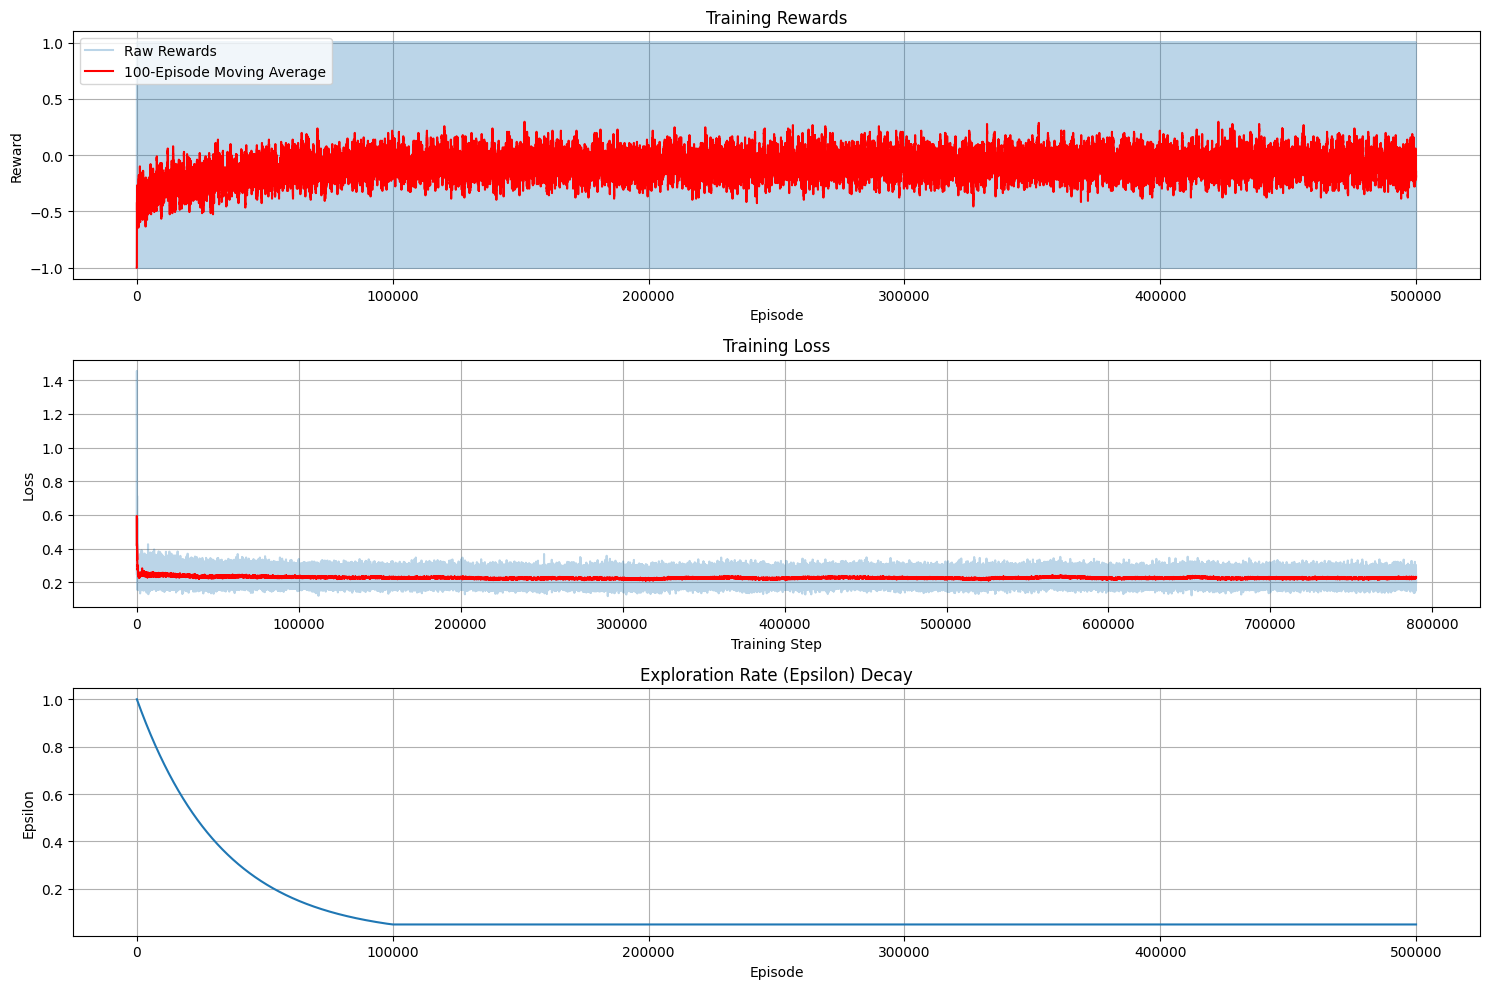

In [11]:
# Plotting functions with improved visualization
def plot_metrics(rewards, losses, epsilons):
    fig = plt.figure(figsize=(15, 10))

    # Plot rewards with moving average
    plt.subplot(311)
    plt.plot(rewards, alpha=0.3, label='Raw Rewards')
    window_size = 100
    moving_avg = [np.mean(rewards[max(0, i-window_size):i+1])
                 for i in range(len(rewards))]
    plt.plot(moving_avg, 'r', label=f'{window_size}-Episode Moving Average')
    plt.title('Training Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True)

    # Plot losses with moving average
    plt.subplot(312)
    plt.plot(losses, alpha=0.3, label='Raw Losses')
    moving_avg_loss = [np.mean(losses[max(0, i-window_size):i+1])
                       for i in range(len(losses))]
    plt.plot(moving_avg_loss, 'r', label=f'{window_size}-Episode Moving Average')
    plt.title('Training Loss')
    plt.xlabel('Training Step')
    plt.ylabel('Loss')
    plt.grid(True)

    # Plot epsilon decay
    plt.subplot(313)
    plt.plot(epsilons)
    plt.title('Exploration Rate (Epsilon) Decay')
    plt.xlabel('Episode')
    plt.ylabel('Epsilon')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot training metrics
plot_metrics(rewards, losses, epsilons)

## Visualization of the Training of the Non-Noisy Double DQN Model

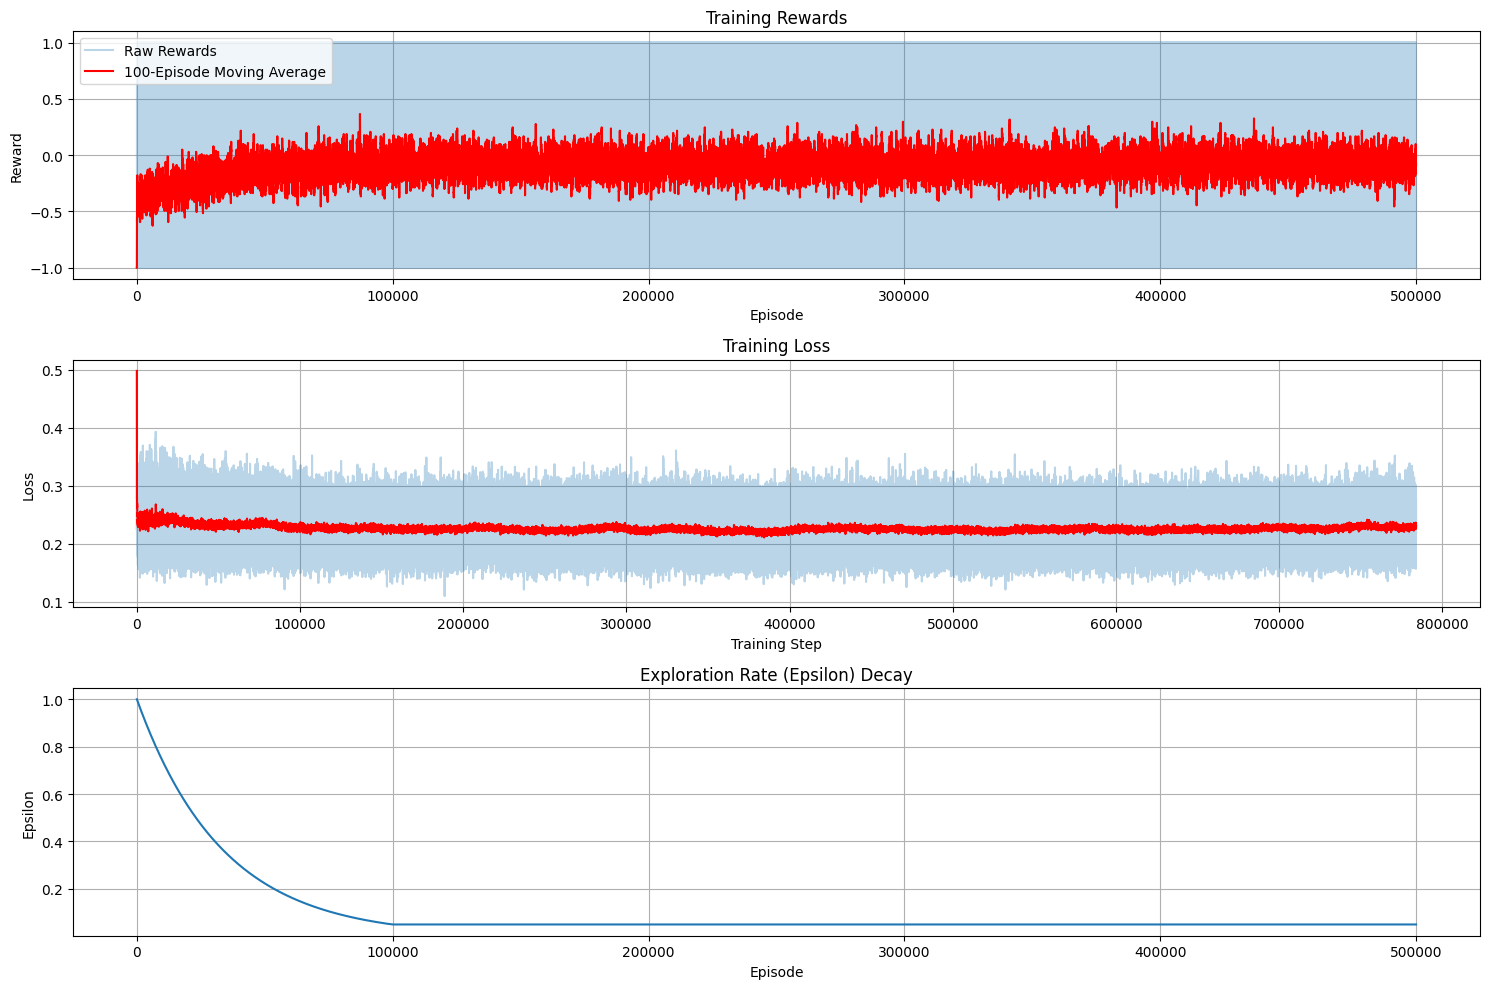